<a href="https://colab.research.google.com/github/johnznjmz/pzn_scraper/blob/main/PZN_scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import re
import sqlite3
from datetime import datetime

import pandas as pd
import requests
from bs4 import BeautifulSoup

date = datetime.now()
conn = sqlite3.connect('pzn_price.db')  # Db name
c = conn.cursor()

pzns = pd.read_csv("PZN_Ö.csv")  # Edit-- copy paste the your file path, file should contain column 'pzn'
urls = []  # create a list of urls for every pzn and save to the list 'urls'

for pzn in pzns['pzn']:
    query_urls = "https://www.apomio.de/suche?query=" + str(pzn)
    mehr_angebote_url = "https://www.apomio.de/preisvergleich-zeige-alle-angebote/" + str(pzn)

    urls.append(query_urls)
    urls.append(mehr_angebote_url)


# parse each url using BeautifulSoup
def parse(url):
    header = {
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36",
        'referer': 'https://www.google.com/'}
    html = requests.get(url, headers=header)
    parse_text = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    return parse_text


# Create a data frame from parse text
def create_table():
    soup = parse(url)

    data = pd.DataFrame(columns=['Pzn',
                                 'Competitor_name',
                                 'Competitor_shop_price',
                                 'Versand_cost',
                                 'Gesamtkosten',
                                 'Last_preis_update',
                                 'Created_at'])

    for each in soup.find_all('div', id=re.compile("comparisonRow")):  # Find div with matching id "comparisonRow"
        try:
            competitor_name = each.find(class_='w-5/6 block text-xs text-black-darker mb-2').text.replace(
                '\n','').replace(" ", "")   # Find text in a class, otherwsie append 'None'
        except:
            competitor_name = 'None'
        try:
            competitor_shop_price = each.find(class_="text-red text-xl font-bold no-underline block mb-1").text.replace(
                "\n", '').replace("€", "").replace(" ", "").replace(",", ".")
        except:
            competitor_shop_price = 'None'
        try:
            versand_cost = each.find(class_="block text-xs text-black-darker mb-1").text.replace(
                "Versand", "").replace("'", "").replace("€", "")
        except:
            versand_cost = 'None'
        try:
            last_preis_update = each.find(class_="block text-xxs text-black-darker").text.replace(
                "Preis vom", "").replace(". Preis kann jetzt höher sein.**", "")
        except:
            last_preis_update = 'None'
        try:
            gesamtkosten = each.find(class_="block text-xs text-black font-medium").text.replace(
                "\n", '').replace("Gesamtkosten", "").replace(" ", "").replace("€", "").replace(",", ".")
        except:
            gesamtkosten = 'None'

        created_at = date.strftime("%d/%m/%Y %H:%M:%S")  # scrape time
        pzn_id = re.sub("[^0-9]", "", url)  # pzn_id from url

        data = data.append({'Pzn': pzn_id, 'Competitor_name': competitor_name,
                            'Competitor_shop_price': competitor_shop_price,
                            'Versand_cost': versand_cost,
                            'Gesamtkosten': gesamtkosten,
                            'Last_preis_update': last_preis_update,
                            'Created_at': created_at},
                           ignore_index=True)
    return data


# Create table
for url in urls:
    product_price = create_table()

    c.execute(
        'CREATE TABLE IF NOT EXISTS Price ("Pzn" INT NOT NULL,"Competitor_Name" VARCHAR NOT NULL,"Competitor_shop_price" FLOAT NOT NULL,"Versand_cost" VARCHAR NOT NULL,"Gesamtkosten" FLOAT NOT NULL,"Last_preis_update" VARCHAR NOT NULL,"Created_at" VARCHAR NOT NULL)')
    conn.commit()

    product_price.to_sql('Price', conn, if_exists='append', index=False)

In [209]:
conn = sqlite3.connect('pzn_price.db')

pd.read_sql_query("SELECT * FROM Price ", conn)


,Pzn,Competitor_Name,Competitor_shop_price,Versand_cost,Gesamtkosten,Last_preis_update,Created_at
0,171865,Best-arznei.de-rundumgutversorgt,61.39,versandkostenfrei,61.39,19.11.2020 06:36,19/11/2020 06:27:05
1,171865,eurapon.de,61.44,versandkostenfrei,61.44,19.11.2020 02:23,19/11/2020 06:27:05
2,171865,vitafy.de,61.92,versandkostenfrei,61.92,18.11.2020 12:00,19/11/2020 06:27:05
3,171865,APONEO–MehralsApotheke,62.92,versandkostenfrei,62.92,19.11.2020 02:10,19/11/2020 06:27:05
4,171865,APONSApothekefürMensch&Tier,62.92,"4,50",67.42,05.10.2020 02:13,19/11/2020 06:27:05
...,...,...,...,...,...,...,...
339,13839425,naturheilkunde-shop24,44.06,"5,25",49.31,18.11.2020 18:24,19/11/2020 06:27:05
340,13839425,ApoluxVersandapotheke,44.45,"3,95",48.40,18.11.2020 13:00,19/11/2020 06:27:05
341,13839425,besamex–IhreApothekebringt's,44.83,versandkostenfrei,44.83,19.11.2020 07:24,19/11/2020 06:27:05
342,13839425,a-buy24derGeorgs-Marien-Apotheke,44.83,versandkostenfrei,44.83,19.11.2020 06:36,19/11/2020 06:27:05


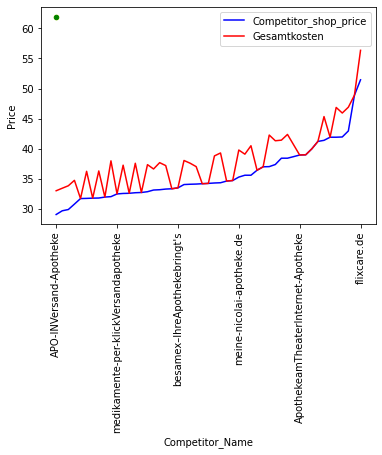

In [210]:
import matplotlib.pyplot as plt

pzn_sort = pd.read_sql_query("SELECT * FROM Price WHERE Pzn = 4002065", conn)
vitafy = pzn_srt[pzn_srt.Competitor_Name.str.contains('vitafy',case=False)]
ax = plt.gca()

pzn_sort.plot(kind='line',x='Competitor_Name',y='Competitor_shop_price',color='blue',ax=ax)
pzn_sort.plot(kind='line',x='Competitor_Name',y='Gesamtkosten', color='red', ax=ax)
vitafy.plot(kind='scatter',x='Competitor_Name',y='Competitor_shop_price', color='yellow', ax=ax)
vitafy.plot(kind='scatter',x='Competitor_Name',y='Gesamtkosten', color='green', ax=ax)

plt.xticks(rotation=90)
ax.set_ylabel('Price')
plt.show()